## Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## **Marks: 40**
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



### We will do the following steps:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

#### Uncomment the code given below, and run the line of code to install featuretools library

In [ ]:
# Uncomment the code given below, and run the line of code to install featuretools library

#!pip install featuretools==0.27.0

### Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
      conda install -c conda-forge featuretools==0.27.0

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [6]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('/content/sample_data/trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("/content/sample_data/pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("/content/sample_data/dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Load the Datasets

In [7]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


### Display first five rows

In [8]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


### Display info of the dataset

In [9]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are 974409 non null values in the dataset

### Check the number of unique values in the dataset.

In [10]:
# Check the uniques values in each columns
trips.nunique()

id                      974409
vendor_id                    2
pickup_datetime         939015
dropoff_datetime        938873
passenger_count              8
trip_distance             2503
pickup_longitude         20222
pickup_latitude          40692
dropoff_longitude        26127
dropoff_latitude         50077
payment_type                 4
trip_duration             3607
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

**Write your answers here:_____**
- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors are there. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### Question 1 : Check summary statistics of the dataset (1 Mark)

In [ ]:
#chekcing the descriptive stats of the data

#Remove _________ and complete the code

trips._____________

In [11]:
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259282,294491.646773,0.000000,254521.000000,509310.000000,764743.000000,1.020002e+06
passenger_count,974409.0,1.664010,1.314975,0.000000,1.000000,1.000000,2.000000,9.000000e+00
trip_distance,974409.0,2.734356,3.307038,0.000000,1.000000,1.640000,2.990000,5.028000e+02
pickup_longitude,974409.0,-73.973275,0.035702,-74.029846,-73.991058,-73.981178,-73.966888,-7.377051e+01
pickup_latitude,974409.0,40.752475,0.026668,40.630268,40.739689,40.755390,40.768929,4.084991e+01
dropoff_longitude,974409.0,-73.972825,0.031348,-74.029945,-73.990356,-73.979156,-73.962769,-7.377002e+01
dropoff_latitude,974409.0,40.753046,0.029151,40.630009,40.738792,40.755650,40.770454,4.085000e+01
trip_duration,974409.0,797.702753,576.802176,0.000000,389.000000,646.000000,1040.000000,3.606000e+03


**Write your answers here:_____**

The median and 75% of the passenger count is 1 and 2 respectively.

Mean trip distance is 2.73 miles.

Average trip duration is ~798 sec. we would like to predict trip duration as a dependent variable of other features.




#### Checking for the rows for which trip_distance is 0

In [12]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


**Write your answers here:_____**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### Replacing the 0 values with median of the trip distance

In [13]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [14]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### Checking for the rows for which trip_duration is 0

In [15]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1,0.0,R,Z
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,1.64,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
172653,180414,1,2016-02-04 19:23:45,2016-02-04 19:23:45,1,0.40,-73.990868,40.751106,-73.990868,40.751106,2,0.0,D,D
173013,180795,1,2016-02-04 20:23:10,2016-02-04 20:23:10,1,0.80,-73.977661,40.752968,-73.977661,40.752968,2,0.0,AD,AD


**Write your answers here:_____**
- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [16]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [18]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

### Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

In [ ]:
#Remove _________ and complete the code
trips._______________
plt.show()

<function matplotlib.pyplot.show>

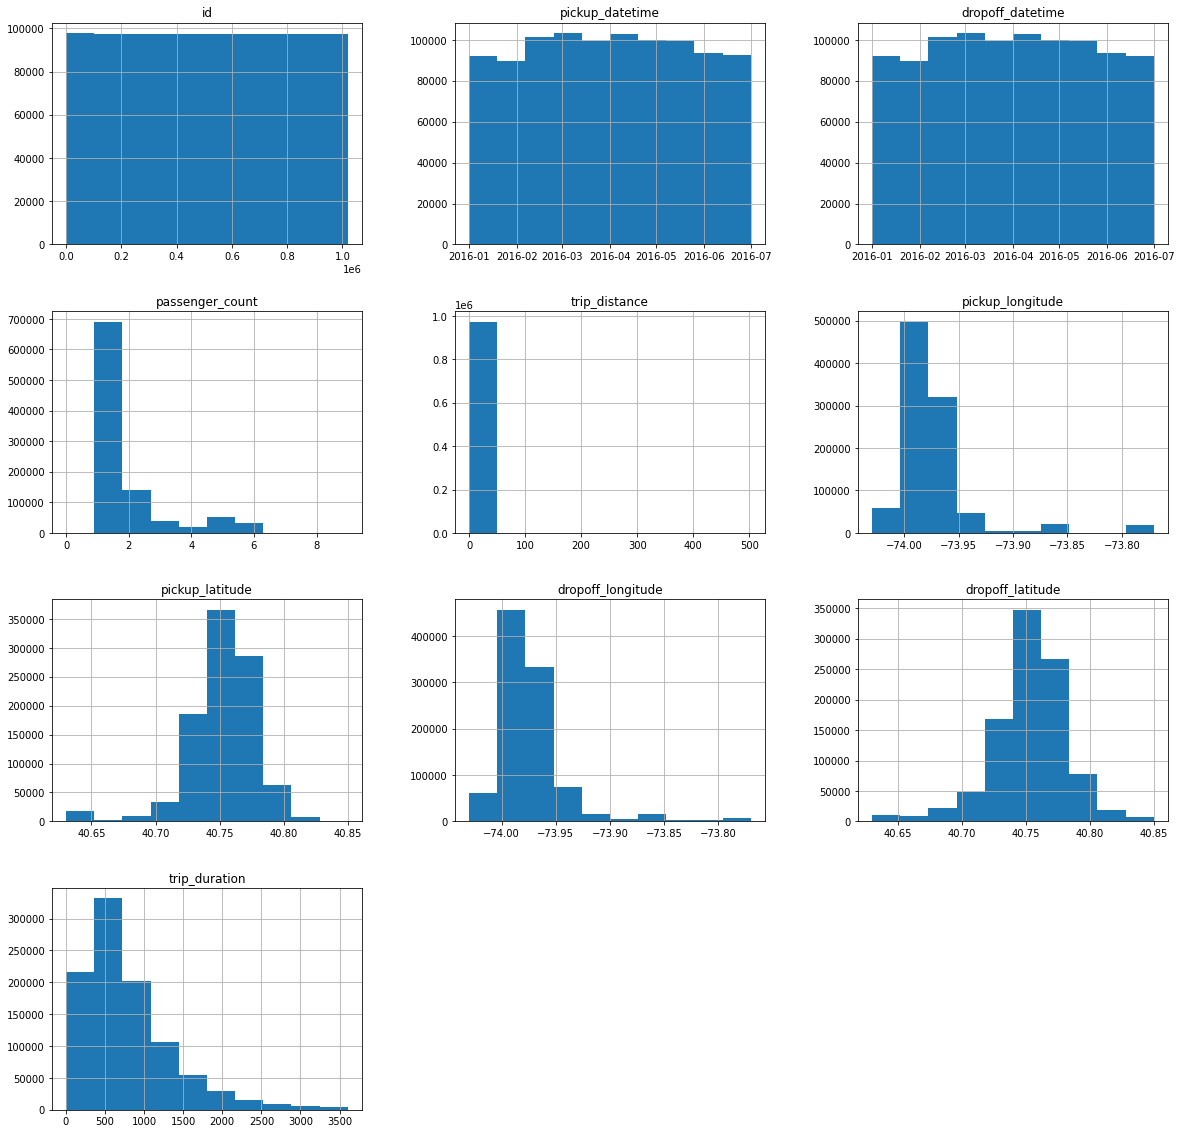

In [23]:
trips.hist(figsize=(20,20))
plt.show

**Write your answers here:_____**

Pickup latitude, dropoff latitude are displaying normal-like distribution, while pickup longitude,dropoff longitude are aright skewed.

Passenger number is right-skewed meaning most people like private rides. Trip duration is also rightly skewed meaning most people take short rides.

Most trip distance seem to be below 50mi. But it appears to have some outlier.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


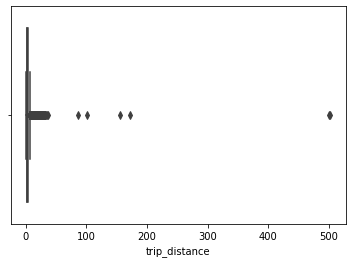

In [24]:
sns.boxplot(trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset, we drop investigate it further

In [25]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

#### Clipping the outliers of trip distance to 50

In [26]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


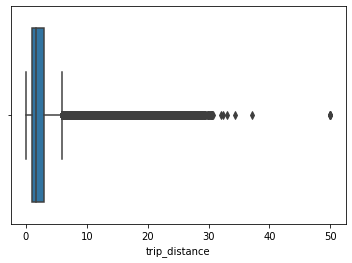

In [27]:
sns.boxplot(trips['trip_distance'])
plt.show()

### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

In [ ]:
#Remove _________ and complete the code

import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(________________)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


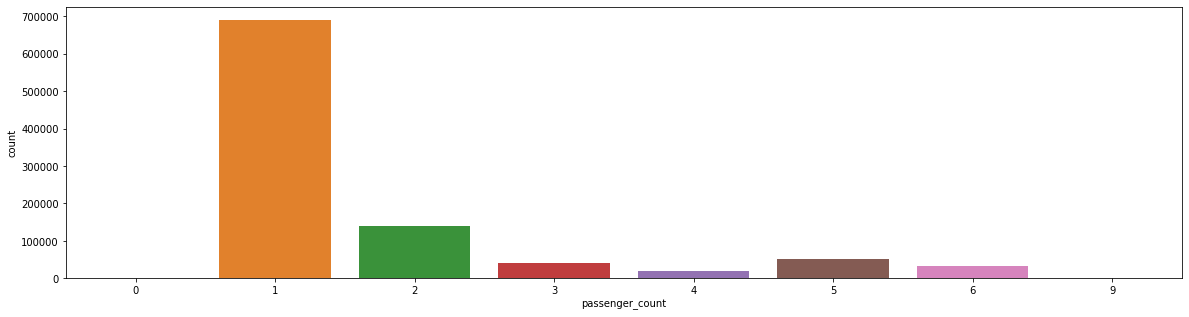

In [28]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(trips['passenger_count'])
plt.show()

In [29]:
trips.passenger_count.value_counts(normalize=True)

1    0.709334
2    0.143419
5    0.053409
3    0.041140
6    0.033334
4    0.019338
0    0.000025
9    0.000002
Name: passenger_count, dtype: float64

**Write your answers here:_____**


Most people (~71%) like to ride by themselves in private. A minority of 14% people share ride with another passengern. Rides with more than 2 passengers, rest of the rides, comprise ~15% of the total rides

### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

In [ ]:
#Remove _________ and complete the code
trips._____________

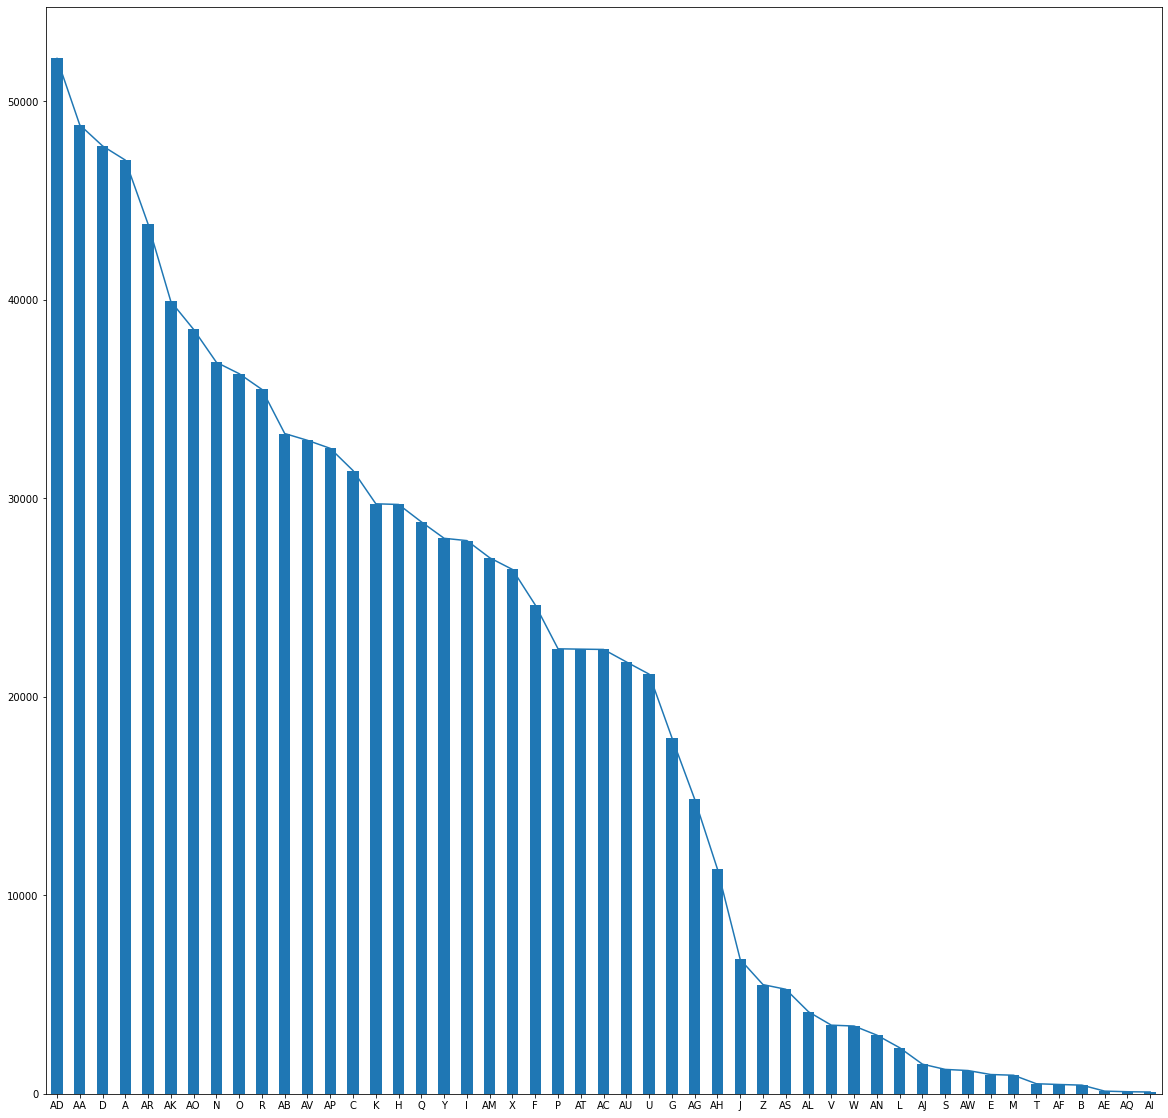

In [35]:
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar',figsize=(20,20))
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='line',figsize=(20,20))

In [ ]:
#Remove _________ and complete the code

trips._______________

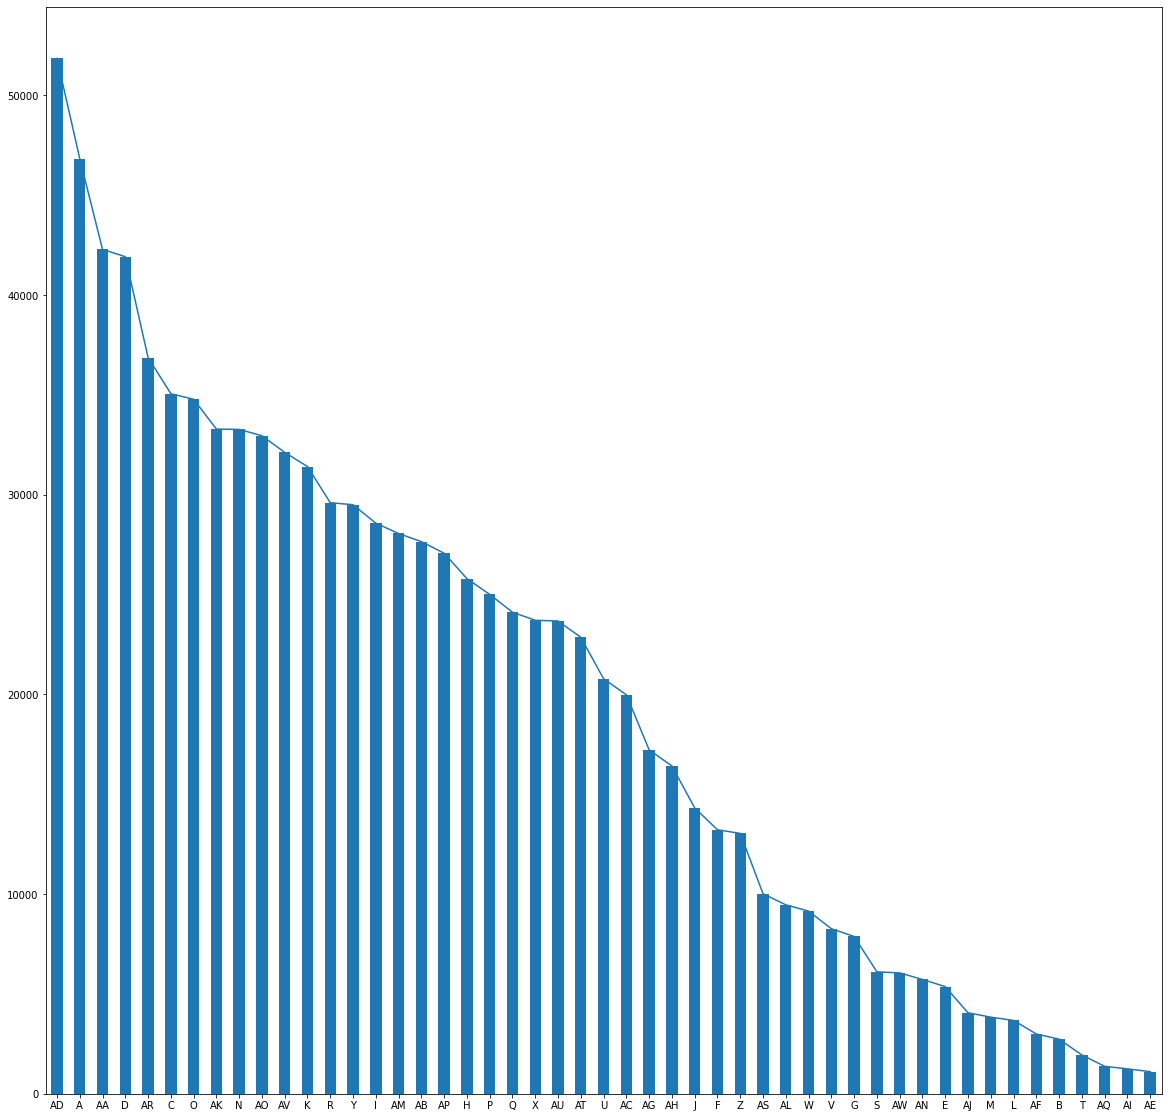

In [36]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar',figsize=(20,20))
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='line',figsize=(20,20))

**Write your answers here:_____**

Most of the pickup and dropoff are from area AD,AA, A and D whereas AE,AQ and AI has the lowest pickups and dropoffs.
This is probably indicative of the most and least busiest neighborhoods respectively.

There is a sharp decline in pick up neighborhoods below 20k rides. However, the drpoff region do not show such precipitous decline. This indicates that people do take more rides from busier neighborhoods such as commercial or metroploiton areas and get dropped off at the residential neighborhoods; but the opposite is not as common.

In [37]:
pickup_neighborhoods.head()

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


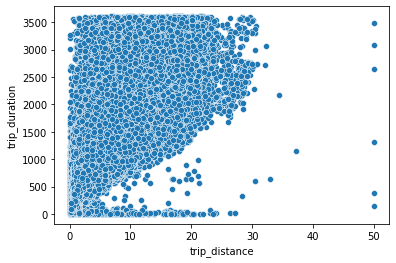

In [38]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


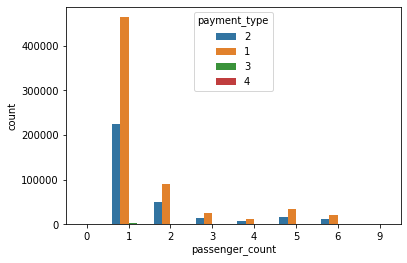

In [40]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In <a <href="https://www.featuretools.com/"><featuretools (automated feature engineering software package)/></a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [ ]:
#Remove _________ and complete the codeV

entities = { __________________ }

#Remove _________ and complete the code
relationships = [_________________________]

In [41]:
entities = {
        "trips": (trips, "id", "pickup_datetime" ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [42]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667608,698423,2016-05-03 17:59:59
667609,698424,2016-05-03 18:00:52
667610,698425,2016-05-03 18:01:06
667611,698426,2016-05-03 18:01:11
667612,698427,2016-05-03 18:01:12
667613,698428,2016-05-03 18:01:12
667614,698429,2016-05-03 18:01:24
667615,698430,2016-05-03 18:01:36
667616,698431,2016-05-03 18:01:39


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [ ]:
#Remove _________ and complete the code
trans_primitives = [_______________]

#Remove _________ and complete the code
features = ft.dfs(entities=______________,
                  relationships=____________________,
                  target_entity="trips",
                  trans_primitives=_________________,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [44]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [45]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

**Question: 4.2 Compute features and define feature matrix**

In [48]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [ ]:
#Remove _________ and complete the code
feature_matrix1 = compute_features(______________)

In [49]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:08 | Progress: 100%|██████████
Finishing computing...


In [50]:
preview(feature_matrix1, 5)

,dropoff_neighborhoods.latitude,IS_WEEKEND(pickup_datetime),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,trip_duration,trip_distance,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.longitude,dropoff_neighborhoods.longitude,passenger_count,vendor_id,IS_WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,payment_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56311,40.721435,False,False,False,False,False,False,False,False,False,False,False,645.0,1.61,False,False,False,False,False,False,False,False,False,False,-73.987205,-73.998366,1,2,False,40.720245,1
698423,40.752186,False,True,False,False,False,False,False,False,False,False,False,523.0,1.12,False,False,False,False,False,True,False,False,False,False,-73.966696,-73.976515,1,2,False,40.764723,2
698424,40.775299,False,False,False,False,False,False,False,True,False,False,False,155.0,0.68,False,False,False,False,False,True,False,False,False,False,-73.966696,-73.960551,1,2,False,40.764723,2
698425,40.793597,False,False,False,False,False,False,False,False,False,False,False,225.0,1.00,False,False,False,False,False,False,False,False,False,False,-73.969822,-73.969822,1,1,False,40.793597,1
698426,40.766809,False,False,False,False,False,False,False,False,False,False,False,372.0,0.70,False,False,False,False,False,False,False,False,False,False,-73.956886,-73.956886,2,1,False,40.766809,2


In [51]:
feature_matrix1.shape

(920378, 31)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### Transforming the duration variable on sqrt and log

(array([  4566.,  35831., 163872., 249551., 225381., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <a list of 10 Patch objects>)

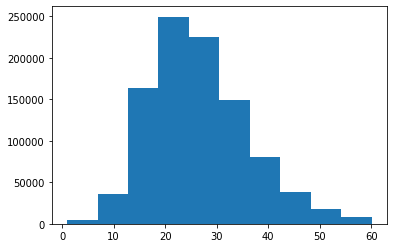

In [52]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69738e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <a list of 10 Patch objects>)

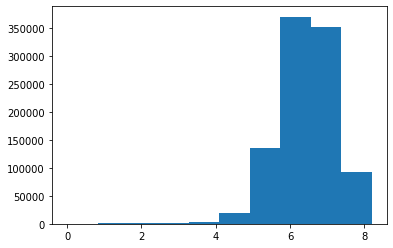

In [53]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

### Splitting the data into train and test

In [55]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [56]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [ ]:
#Remove _________ and complete the code

#defining the model

lr1=_______________

#fitting the model
lr1.___________


In [58]:
lr1= LinearRegression()
lr1.fit(X_train, y_train)


LinearRegression()

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_______________)  

In [60]:
model_pref(lr1, X_train, X_test, y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.576106  6.132169  4.736641
1   Test  0.555831  6.558806  5.024874


**Write your answers here:_____**

Model is giving only 0.57 Rsquared, with RSME of 6.13 and MAE of ~4.74.
Model, very slightly overfitted, is performing roughly equally  in the train set

#### Question 4.4 Building decision tree using only weekend transform primitive

In [ ]:
#Remove _________ and complete the code

#define the model
dt=______________

#fit the model

dt.fit(_________________)

In [61]:
dt= DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_________________)  

In [62]:
model_pref(dt, X_train, X_test, y_train, y_test )

    Data  RSquared      RMSE       MAE
0  Train  0.917069  2.712331  1.518055
1   Test  0.597816  6.241128  4.637539


**Write your answers here:_____**


Model is giving 0.91 Rsquared, with RSME of 2.71 and MAE of 1.51. Model is very overfitted. Per haps pruning is required.

#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [ ]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned=_____________________

#fit the model
dt_pruned.fit(_____________________-)

In [67]:
dt_pruned= DecisionTreeRegressor(max_depth=3)
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_______________)  

In [68]:
model_pref(dt_pruned, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.678355  5.341631  4.093317
1   Test  0.646495  5.851243  4.445388


**Write your answers here:_____**


The pruned model is performing better, but still slightly overfitted 

#### Question 4.6 Building Random Forest using only weekend transform primitive

In [ ]:
#Remove _________ and complete the code

#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [69]:
rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [ ]:
#fit the model

#Remove _________ and complete the code
rf._____________________

In [70]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code

model_pref(___________________________)

In [71]:
model_pref(rf, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738335  4.817902  3.675870
1   Test  0.708329  5.314926  4.018981



The RF model is performing best so far with very slight overfitting but superior R2.

**Write your answers here:_____**


### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

In [ ]:
#Remove _________ and complete the code
trans_primitives = [_____________________________]

#Remove _________ and complete the code
features = ft.dfs(entities=_________,
                  relationships=____________,
                  target_entity="trips",
                  trans_primitives=____________________,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [74]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [75]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [ ]:
#Remove _________ and complete the code
feature_matrix2 = compute_features(______________)

In [76]:
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:09 | Progress: 100%|██████████
Finishing computing...


In [77]:
feature_matrix2.shape

(920378, 41)

In [78]:
feature_matrix2.head()

,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,HOUR(pickup_datetime),IS_WEEKEND(pickup_datetime),MINUTE(pickup_datetime),payment_type,dropoff_neighborhoods.latitude,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.latitude,DAY(dropoff_datetime),trip_duration,MINUTE(dropoff_datetime),passenger_count,MONTH(pickup_datetime),pickup_neighborhoods.longitude,trip_distance,HOUR(dropoff_datetime),WEEKDAY(dropoff_datetime),MONTH(dropoff_datetime),dropoff_neighborhoods.longitude,DAY(pickup_datetime),WEEKDAY(pickup_datetime),vendor_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56311,False,False,False,False,False,False,False,False,False,False,False,0,False,0,1,40.721435,False,False,False,False,False,False,False,False,False,False,40.720245,12,645.0,11,1,1,-73.987205,1.61,0,1,1,-73.998366,12,1,2
56312,False,False,False,False,False,False,False,False,False,False,False,0,False,2,2,40.715828,False,False,False,False,False,False,False,False,False,False,40.646194,12,1270.0,23,1,1,-73.785073,16.15,0,1,1,-73.954298,12,1,2
56313,False,False,False,False,False,False,False,False,False,False,False,0,False,2,1,40.818445,False,False,False,False,False,False,False,False,False,False,40.818445,12,207.0,5,1,1,-73.948046,0.80,0,1,1,-73.948046,12,1,1
56314,False,False,False,False,False,False,False,False,False,False,False,0,False,2,2,40.742531,False,False,False,False,False,False,False,False,False,False,40.729652,12,214.0,6,5,1,-73.991595,1.33,0,1,1,-73.977943,12,1,2
56315,False,False,False,False,False,False,False,False,False,False,False,0,False,3,1,40.818445,False,False,False,False,False,False,False,False,False,False,40.793597,12,570.0,13,1,1,-73.969822,2.35,0,1,1,-73.948046,12,1,2


### Build the new models more transform features

In [79]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [ ]:
#Remove _________ and complete the code

#defining the model

lr2=_______________

#fitting the model
lr2.___________


In [80]:
lr2= LinearRegression()
lr2.fit(X_train2, y_train2)

LinearRegression()

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_______________)  

In [83]:
model_pref(lr2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.623501  5.779195  4.273127
1   Test  0.623651  6.037346  4.537582


**Write your answers here:_____**

The model is performing equally both in train and test with a Rsq of 0.62. RMSE for the training is ~5.8 whereas for test it is~6.

#### Question 5.4 Building Decision tree using more transform primitive

In [ ]:
#Remove _________ and complete the code

#define the model
dt2=______________

#fit the model

dt2.fit(_________________)

In [84]:
dt2=DecisionTreeRegressor()

dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_________)  

In [85]:
model_pref(dt2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.711793  5.283270  3.796043


**Write your answers here:_____**

The model is overfitting a lot, with train Rsq as 1 while test R2 as 0.71. Pruning is required.

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [ ]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned2=_____________________

#fit the model
dt_pruned2.fit(_____________________)

In [86]:
dt_pruned2=DecisionTreeRegressor(max_depth=4)

dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=4)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(_________________________)  

In [87]:
model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.707305  5.095575  3.910334
1   Test  0.679915  5.567791  4.227597


**Write your answers here:_____**

Model is giving ~0.70 Rsquared, with RSME of ~5 and MAE of 3.91. Model performance has improved a little (from 0.67 to 0.7 for the training model) by adding more transform features.

Model is slightly overfitting.

#### Question 5.6 Building Random Forest using more transform primitive

In [ ]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf2._____________________

#fit the model

#Remove _________ and complete the code
rf2._____________________

In [89]:
rf2=RandomForestRegressor(n_estimators=60,max_depth=7)

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(________________)  

In [90]:
model_pref(rf2, X_train2, X_test2,y_train2,y_test2) 

    Data  RSquared      RMSE       MAE
0  Train  0.775297  4.464673  3.361282
1   Test  0.752580  4.895170  3.638162


**Write your answers here:_____**


The Rsq for the model with more transform primitive is 78% which is better than the single transform feature model (74%). Athough the model is very little overfitted multiple random forest model transform feature has significantly improved the score

**Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

The Rsq for the model with more transform primitive is 78% which is better than the single transform feature model (74%). Athough the model is very little overfitted multiple random forest model transform feature has significantly improved the score

**Write your answers here:_____**

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

### Question 6: Create a Models with transform and aggregate primitive. (10 Marks)
**6.1 Define more transform and aggregate primitive and define features using dfs?**

In [ ]:
#Remove _________ and complete the code

trans_primitives = [____________]
aggregation_primitives = [____________________]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [91]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [92]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

**Question: 6.2 Compute features and define feature matrix**

In [ ]:
#Remove _________ and complete the code
feature_matrix3 = compute_features(_______________)

In [93]:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:18 | Progress: 100%|██████████
Finishing computing...


In [94]:
feature_matrix3.head()

,MINUTE(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = AR,dropoff_neighborhood = C,dropoff_neighborhood = O,dropoff_neighborhood = N,dropoff_neighborhood = AK,dropoff_neighborhood = AO,dropoff_neighborhoods.MEAN(trips.trip_distance),trip_duration,pickup_neighborhoods.STD(trips.trip_duration),pickup_neighborhoods.MEDIAN(trips.trip_duration),HOUR(dropoff_datetime),pickup_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhoods.MAX(trips.passenger_count),pickup_neighborhoods.longitude,MONTH(pickup_datetime),WEEKDAY(dropoff_datetime),pickup_neighborhoods.MEAN(trips.trip_duration),dropoff_neighborhoods.SUM(trips.trip_distance),dropoff_neighborhoods.MEDIAN(trips.trip_duration),dropoff_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.STD(trips.trip_duration),pickup_neighborhoods.MIN(trips.trip_duration),pickup_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.COUNT(trips),WEEKDAY(pickup_datetime),dropoff_neighborhoods.MAX(trips.trip_duration),dropoff_neighborhoods.MIN(trips.trip_distance),pickup_neighborhoods.MAX(trips.trip_distance),DAY(dropoff_datetime),IS_WEEKEND(dropoff_datetime),dropoff_neighborhoods.MIN(trips.trip_duration),trip_distance,payment_type,passenger_count,dropoff_neighborhoods.MEAN(trips.trip_duration),dropoff_neighborhoods.SUM(trips.trip_duration),pickup_neighborhoods.MEDIAN(trips.trip_distance),IS_WEEKEND(pickup_datetime),dropoff_neighborhoods.MAX(trips.trip_distance),pickup_neighborhoods.latitude,MINUTE(pickup_datetime),pickup_neighborhoods.COUNT(trips),vendor_id,dropoff_neighborhoods.SUM(trips.passenger_count),pickup_neighborhoods.MIN(trips.passenger_count),MONTH(dropoff_datetime),pickup_neighborhoods.SUM(trips.trip_duration),pickup_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.latitude,pickup_neighborhoods.SUM(trips.passenger_count),dropoff_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.longitude,pickup_neighborhoods.STD(trips.passenger_count),DAY(pickup_datetime),dropoff_neighborhoods.MEDIAN(trips.trip_distance),dropoff_neighborhoods.MEAN(trips.passenger_count),HOUR(pickup_datetime),pickup_neighborhoods.MEAN(trips.passenger_count),pickup_neighborhoods.MAX(trips.trip_duration),dropoff_neighborhoods.STD(trips.passenger_count),pickup_neighborhoods.MAX(trips.passenger_count),pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = A,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,pickup_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56311,11,1.0,False,False,False,False,False,False,False,False,False,False,2.603805,645.0,429.103720,682.5,0,1.0,6,-73.987205,1,1,743.952234,3387.55,668.0,2.776637,495.023673,5.0,2.536758,1301,1,3572.0,0.05,18.57,12,False,1.0,1.61,1,1,776.627978,1010393.0,2.46,False,20.54,40.720245,0,1298,2,2228,1,1,965650.0,0.07,40.721435,2219,1,-73.998366,1.329779,12,1.88,1.712529,0,1.709553,3292.0,1.303984,6,False,False,False,False,False,False,False,False,False,False,3904.70,3.008243
56312,23,1.0,False,False,False,False,False,False,False,False,False,False,4.907919,1270.0,788.720284,2086.0,0,1.0,6,-73.785073,1,1,2064.952800,3656.40,942.0,3.830819,612.281178,1.0,5.243534,745,1,3526.0,0.18,32.30,12,False,4.0,16.15,2,1,1036.722148,772358.0,17.50,False,19.00,40.646194,2,1250,2,1282,1,1,2581191.0,0.01,40.715828,2239,1,-73.954298,1.404130,12,4.05,1.720805,0,1.791200,3604.0,1.335982,6,False,False,False,False,False,False,False,False,False,False,19468.13,15.574504
56313,5,1.0,False,False,False,False,False,False,False,False,False,False,4.865322,207.0,526.288091,513.0,0,1.0,6,-73.948046,1,1,672.408257,2495.91,898.0,3.705997,538.251916,6.0,2.942660,513,1

### Build the new models more transform and aggregate features

In [95]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [ ]:
#Remove _________ and complete the code

#defining the model

lr3=_______________

#fitting the model
lr3.___________


In [97]:
lr3= LinearRegression()
lr3.fit(X_train3, y_train3)
model_pref(lr3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.643423  5.624220  4.134927
1   Test  0.631697  5.972457  4.464424


#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(______________)  

**Write your answers here:_____**

The model is performing similarly on training an test dataset. Using the aggregate features the model Rsq of 0.64 (with RMSE of 5.62 and 4.13 MAE on the training set ) has improved from the previous models (single tranform 0.57 and multiple tranform 0.62) 

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [ ]:
#Remove _________ and complete the code

#define the model
dt3=______________

#fit the model

dt3.fit(_________________)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(________________)  

In [100]:
dt3= DecisionTreeRegressor()
dt3.fit(X_train3, y_train3)
model_pref(dt3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.651888  5.806442  4.187394


**Write your answers here:_____**

The model is very overfitted. Pruning is required.

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [ ]:
#Remove _________ and complete the code
#define the model

#use max_depth=7
dt_pruned3=_____________________

#fit the model
dt_pruned3.fit(_____________________)

#### Check the performance of the model

In [ ]:
#Remove _________ and complete the code
model_pref(___________________)  

In [101]:
dt_pruned3= DecisionTreeRegressor(max_depth=4)
dt_pruned3.fit(X_train3, y_train3)
model_pref(dt_pruned3, X_train3, X_test3, y_train3, y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.707305  5.095575  3.910334
1   Test  0.679915  5.567791  4.227597


**Write your answers here:_____**


The model is still slightly overfitted, pruning has significantly improved the model in terms of fitting. The Rsq is 0.71 is improved with aggregate features (compared to 0.70 with no aggegate features and 0.67 with single transform feature). 

#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [ ]:
#fit the model

#Remove _________ and complete the code
#using (n_estimators=60,max_depth=7)

rf3._____________________

#fit the model

#Remove _________ and complete the code
rf3._____________________

In [102]:
rf3= RandomForestRegressor(max_depth=7, n_estimators=60)
rf3.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [103]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.776529  4.452418  3.354533
1   Test  0.753192  4.889118  3.633145


**Write your answers here:_____**



The model is performing equally in training and test.
The Rsq is ~0.78 which is comparable with the random forest model without the aggegate feature.

**Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:_____**

The training time is way higher for the aggregate transform features. Perfromance-wise the modeling score has not improved much after adding aggregate transforms. This indicates that adding more features in this case was not very useful pefromance-wise.

Random forest using multiple tranform features (rf2 model) performed the best.

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [106]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 523.86925198,  218.58283285,  661.45340445, ...,  185.5610582 ,
       1040.27042676, 1766.44979179])

### Question 7: What are some important features based on model2 and how can they affect the duration of the rides? (3 Marks)

In [ ]:
feature_importances(___________________________)

In [105]:
feature_importances (rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.037
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: pickup_neighborhoods.longitude, 0.003
6: Feature: WEEKDAY(pickup_datetime), 0.003
7: Feature: IS_WEEKEND(dropoff_datetime), 0.003
8: Feature: WEEKDAY(dropoff_datetime), 0.003
9: Feature: vendor_id, 0.002
10: Feature: IS_WEEKEND(pickup_datetime), 0.002


**Write your answers here:_____**


Data indicates Trip distance is the most important predictor of trip duration, which is intuitive.
Features like dropoff_datetime, pickup_datetime, dropoff_neighborhoods.longitude, pickup_neighborhoods.longitude dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude signifies that trip duration is impacted by pickup and dropoff locations.